# Exercise:


## Use your own data or a segmentation dataset available in pytorch and make a UNet architecture.


### Import relevant packages

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from google.colab import drive
from PIL import Image
import os
import numpy as np
import time

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### I will use a semantic segmentation dataset from Kaggle. I downloaded it and copied it in my google drive. You can use your own :)
https://www.kaggle.com/datasets/hammadjavaid/multi-source-satellite-imagery-for-segmentation





In [ ]:
# The images and masks are in RGB form. To train a semantic segmentation model, each object should be treated as class, e.g. 0,1,2, and not as colors
# Define the color map and corresponding class index
COLOR_MAP = {
    (60, 16, 152): 0,  # Building
    (132, 41, 246): 1,  # Land (unpaved area)
    (110, 193, 228): 2,  # Road
    (254, 221, 58): 3,  # Vegetation
    (226, 169, 41): 4,  # Water
    (155, 155, 155): 5  # Unlabeled
}

# To convert the RGB mask into classes
def rgb_to_class(mask):
    mask = np.array(mask)
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    for rgb, class_idx in COLOR_MAP.items():
        class_mask[(mask == rgb).all(axis=-1)] = class_idx

    return Image.fromarray(class_mask)

#Create a custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # If image name is same as the mask name, next line is not needed
        mask_filename = mask_path.replace('image', 'mask').replace('.jpg', '.png')

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_filename).convert("RGB")

        mask = rgb_to_class(mask)


        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask).squeeze().long()

        return image, mask

transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize(size = (256, 256), interpolation = Image.NEAREST),
    transforms.PILToTensor(),
])


image_dir = './drive/MyDrive/Fall2024_DeepLearning/Week5/Segmentation_Dataset/images'
mask_dir = './drive/MyDrive/Fall2024_DeepLearning/Week5/Segmentation_Dataset/masks'


dataset = SegmentationDataset(image_dir, mask_dir, transform_image=transform_image, transform_mask=transform_mask)


### Check some of the properties of the data set

In [ ]:
num_training_samples = len(dataset)
print(f"Number of samples in the dataset: {num_training_samples}")


Number of samples in the dataset: 203


### Setting up the data sets for training and testing

Shape of X [N, C, H, W]: torch.Size([16, 3, 256, 256])
Shape of y: torch.Size([16, 256, 256]) torch.int64


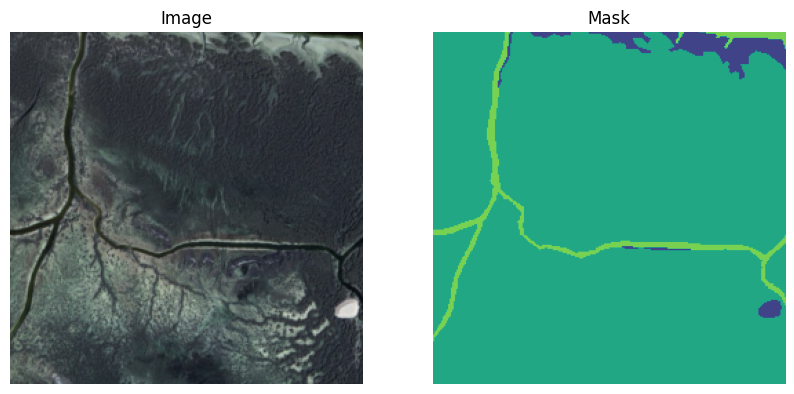

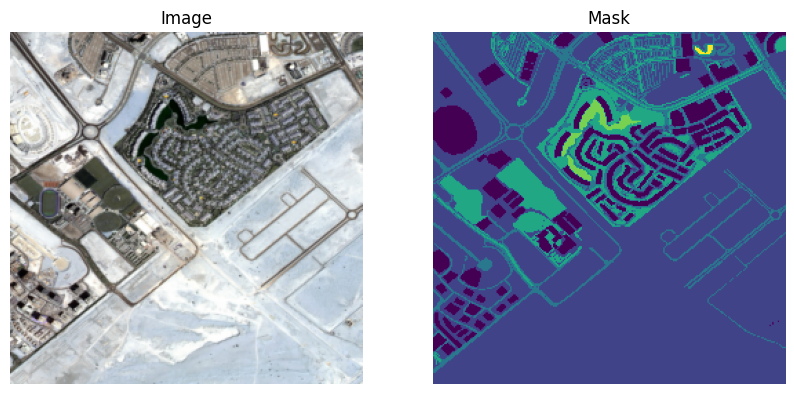

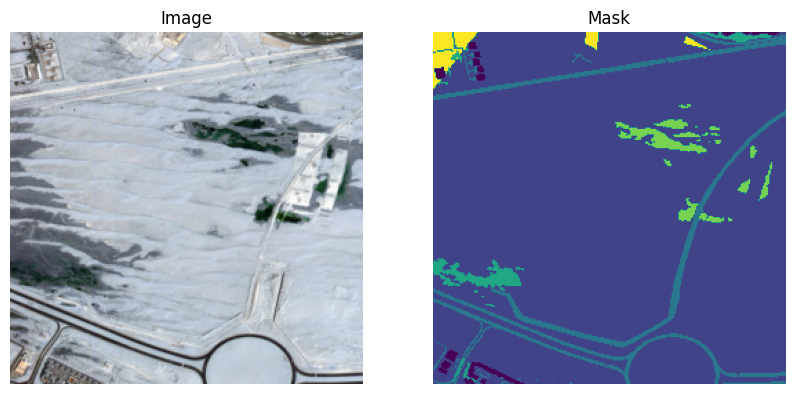

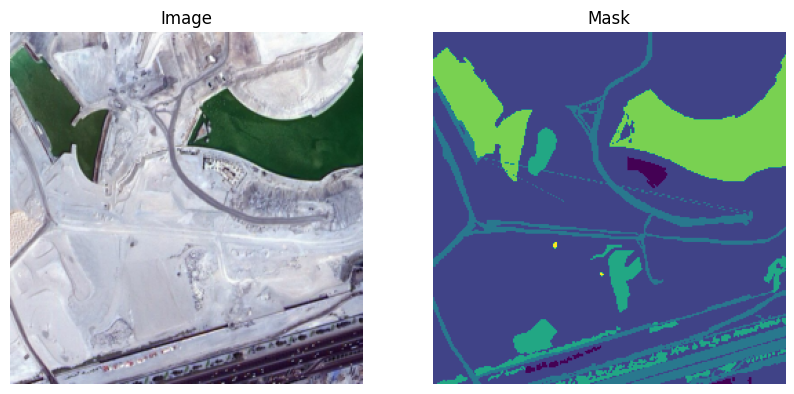

In [ ]:
total_size = len(dataset)
train_size = int(0.90 * total_size)  # 90% for train
val_size = int(0.05 * total_size)  # 5% for validation
test_size = total_size - train_size - val_size # remaining for test

# Use random_split to divide the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

data_loader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
data_loader_val = DataLoader(val_dataset, batch_size=4, shuffle=False)
data_loader_test = DataLoader(test_dataset, batch_size=4, shuffle=False)




# Display an example
def show_image_mask(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.permute(1, 2, 0))  # Permute to convert (C, H, W) to (H, W, C)
    ax1.set_title('Image')
    ax1.axis('off')

    ax2.imshow(mask.squeeze(), vmin = 0, vmax = 5)
    ax2.set_title('Mask')
    ax2.axis('off')

    plt.show()

# Display examples
for images, masks in data_loader_train:
    print(f"Shape of X [N, C, H, W]: {images.shape}")
    print(f"Shape of y: {masks.shape} {masks.dtype}")

    for i in range(4):
        show_image_mask(images[i], masks[i])
    break


### Defining the U-Net architecture simple convolutional network architecture. Note that my input has three channels, so I will start from three channels instead of one as shown in the architecture.

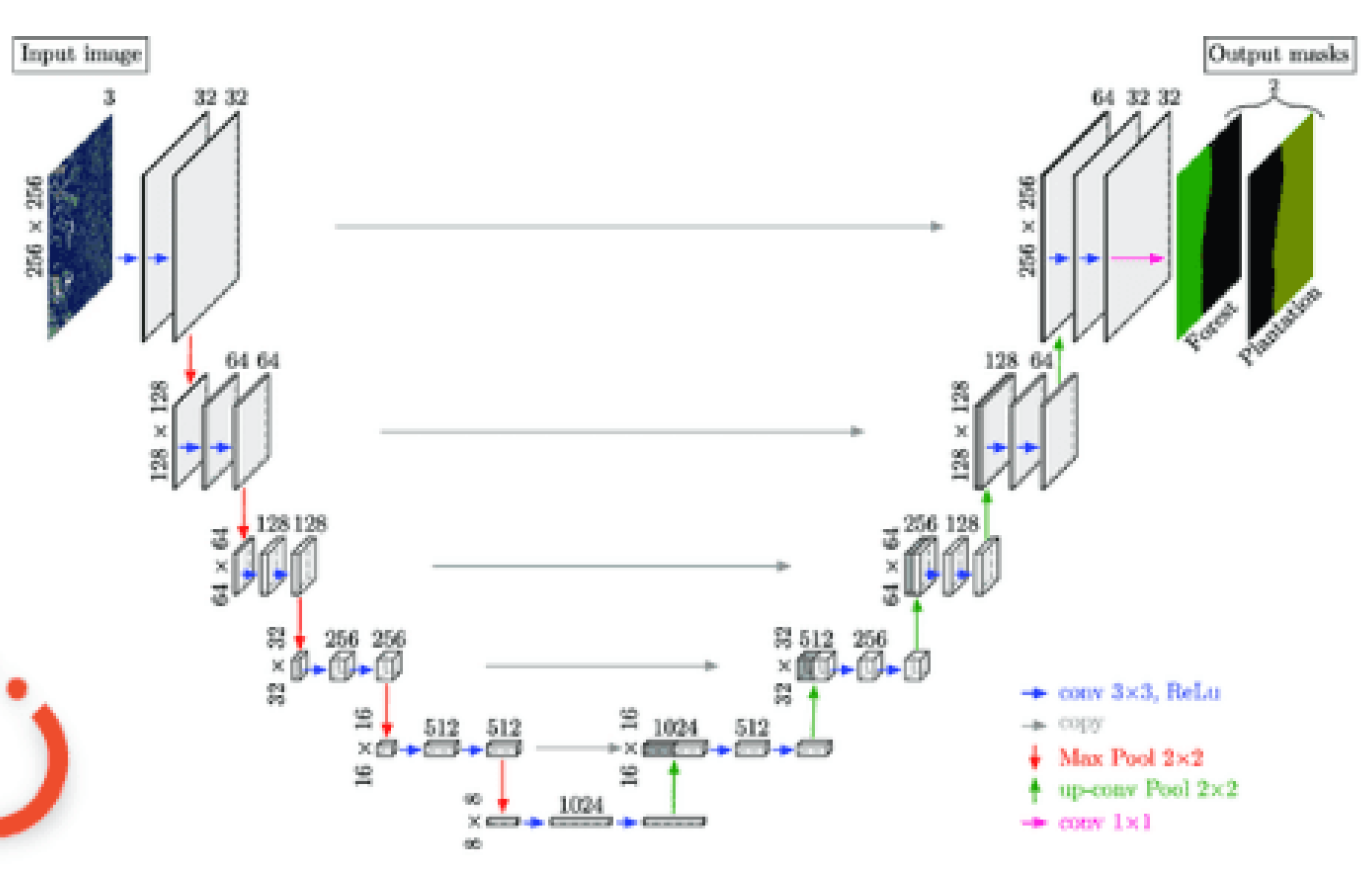


In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1a = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=3, stride=1, padding='same')
        self.relu  = nn.ReLU(inplace=True)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1b = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size=3, stride=1, padding='same')

        self.conv2a = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, stride=1, padding='same')
        self.conv2b = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, stride=1, padding='same')

        self.conv3a = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding='same')
        self.conv3b = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, stride=1, padding='same')

        self.conv4a = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, stride=1, padding='same')
        self.conv4b = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, stride=1, padding='same')

        self.conv5a = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3, stride=1, padding='same')
        self.conv5b = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, stride=1, padding='same')

        self.conv6a = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=3, stride=1, padding='same')
        self.conv6b = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, stride=1, padding='same')

        self.upconv5 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)

        self.conv5c = nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size=3, stride=1, padding='same')
        self.conv5d = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, stride=1, padding='same')

        self.upconv4 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)

        self.conv4c = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size=3, stride=1, padding='same')
        self.conv4d = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, stride=1, padding='same')

        self.upconv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)

        self.conv3c = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size=3, stride=1, padding='same')
        self.conv3d = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, stride=1, padding='same')

        self.upconv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)

        self.conv2c = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride=1, padding='same')
        self.conv2d = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, stride=1, padding='same')

        self.upconv1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2)

        self.conv1c = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=3, stride=1, padding='same')
        self.conv1d = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size=3, stride=1, padding='same')

        self.conv1x1 = nn.Conv2d(in_channels = 32, out_channels = 6, kernel_size=1, stride=1, padding='same')

    def forward(self, x):
      x = self.conv1a(x)
      x = self.relu(x)
      x = self.conv1b(x)
      x1 = self.relu(x)
      x = self.pool(x1)
      x = self.conv2a(x)
      x = self.relu(x)
      x = self.conv2b(x)
      x2 = self.relu(x)
      x = self.pool(x2)
      x = self.conv3a(x)
      x = self.relu(x)
      x = self.conv3b(x)
      x3 = self.relu(x)
      x = self.pool(x3)
      x = self.conv4a(x)
      x = self.relu(x)
      x = self.conv4b(x)
      x4 = self.relu(x)
      x = self.pool(x4)
      x = self.conv5a(x)
      x = self.relu(x)
      x = self.conv5b(x)
      x5 = self.relu(x)
      x = self.pool(x5)
      x = self.conv6a(x)
      x = self.relu(x)
      x = self.conv6b(x)
      x6 = self.relu(x)

      x = self.upconv5(x6)
      x = torch.cat([x, x5], dim=1)
      x = self.conv5c(x)
      x = self.relu(x)
      x = self.conv5d(x)
      x = self.relu(x)

      x = self.upconv4(x)
      x = torch.cat([x, x4], dim=1)
      x = self.conv4c(x)
      x = self.relu(x)
      x = self.conv4d(x)
      x = self.relu(x)

      x = self.upconv3(x)
      x = torch.cat([x, x3], dim=1)
      x = self.conv3c(x)
      x = self.relu(x)
      x = self.conv3d(x)
      x = self.relu(x)

      x = self.upconv2(x)
      x = torch.cat([x, x2], dim=1)
      x = self.conv2c(x)
      x = self.relu(x)
      x = self.conv2d(x)
      x = self.relu(x)

      x = self.upconv1(x)
      x = torch.cat([x, x1], dim=1)
      x = self.conv1c(x)
      x = self.relu(x)
      x = self.conv1d(x)
      x = self.relu(x)

      x = self.conv1x1(x)
      return x

model = NeuralNetwork().to(device)

input = torch.rand(4, 3, 256, 256).to(device) # Shape: [batch_size, channels, depth, height, width]
with torch.no_grad():
    output = model(input)
    print('Output Shape', output.shape)  # Output shape



Using cuda device
Output Shape torch.Size([4, 6, 256, 256])


In [ ]:
def train_loop(model, dataloader, optimizer, device, criterion):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_batches = len(dataloader)
    start_time = time.time()

    for batch, (images, masks) in enumerate(dataloader):
        batch_start_time = time.time()

        images = images.to(device)
        masks = masks.to(device)
        # if torch.isnan(images).any() or torch.isnan(masks).any():
        #     print(f"NaN detected in batch {batch + 1} inputs or masks, skipping this batch.")
        #     break
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        batch_end_time = time.time()

        print(f' Epoch: {epoch}, Batch {batch + 1}/{total_batches}, Batch Loss: {loss.item():.4f}, Time per batch: {batch_end_time - batch_start_time:.3f} s')

    epoch_end_time = time.time()
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch}, Total Train Loss: {epoch_loss:.4f}, Time per epoch: {epoch_end_time - start_time:.3f} seconds')

    return epoch_loss

def validate(model, dataloader, device, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():  # For evaluation, we don't need gradients
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch}, Total Val Loss: {epoch_loss:.4f}')

    return epoch_loss



 Epoch: 0, Batch 1/12, Batch Loss: 1.8429, Time per batch: 0.646 s
 Epoch: 0, Batch 2/12, Batch Loss: 1.8038, Time per batch: 0.382 s
 Epoch: 0, Batch 3/12, Batch Loss: 1.8312, Time per batch: 0.365 s
 Epoch: 0, Batch 4/12, Batch Loss: 1.8211, Time per batch: 0.345 s
 Epoch: 0, Batch 5/12, Batch Loss: 1.8040, Time per batch: 0.369 s
 Epoch: 0, Batch 6/12, Batch Loss: 1.7606, Time per batch: 0.350 s
 Epoch: 0, Batch 7/12, Batch Loss: 1.7211, Time per batch: 0.355 s
 Epoch: 0, Batch 8/12, Batch Loss: 1.5298, Time per batch: 0.369 s
 Epoch: 0, Batch 9/12, Batch Loss: 38.4399, Time per batch: 0.346 s
 Epoch: 0, Batch 10/12, Batch Loss: 1.5014, Time per batch: 0.377 s
 Epoch: 0, Batch 11/12, Batch Loss: 1.6576, Time per batch: 0.363 s
 Epoch: 0, Batch 12/12, Batch Loss: 1.6955, Time per batch: 0.210 s
Epoch: 0, Total Train Loss: 4.9538, Time per epoch: 395.429 seconds
Epoch: 0, Total Val Loss: 1.7019
 Epoch: 1, Batch 1/12, Batch Loss: 1.6634, Time per batch: 0.364 s
 Epoch: 1, Batch 2/12, B

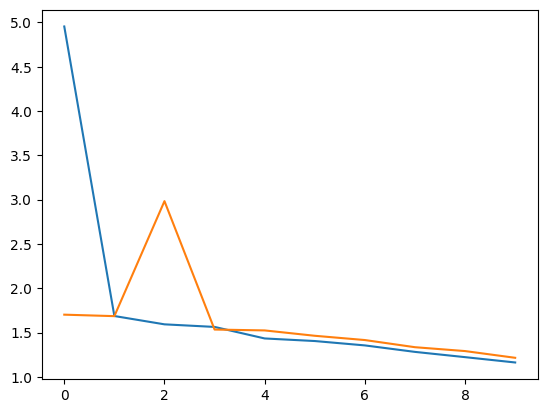

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10 # Define the number of epochs
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train_loop(model, data_loader_train, optimizer, device, criterion)
    val_loss = validate(model, data_loader_val, device, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.plot(train_losses)
plt.plot(val_losses)


# Check result for one image

Text(0.5, 1.0, 'Prediction')

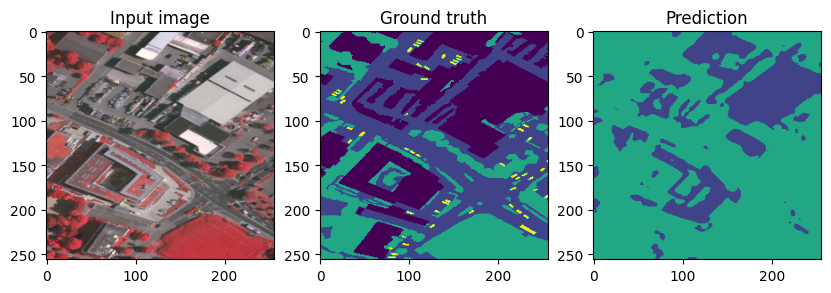

In [ ]:
model.eval()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
example_image, example_mask = val_dataset[0]
ax1.imshow(example_image.permute(1,2,0))
ax1.set_title('Input image')
ax2.imshow(example_mask, vmin = 0, vmax = 5)
ax2.set_title('Ground truth')
with torch.no_grad():
  x = example_image.to(device)
  pred = model(x.unsqueeze(0))
  _, preds = torch.max(pred, 1)
ax3.imshow(preds.squeeze().cpu(), vmin = 0, vmax = 5)
ax3.set_title('Prediction')
